Este experimento consiste en estudiar el algoritmo de **KNN+PCA** para encontrar los mejores parámetros $k$ y $\alpha$ con mejor $accuracy$.

In [1]:
import numpy as np
import pandas as pd
import sentiment
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from tqdm import tqdm_notebook as tqdm

#Cargo datos
df = pd.read_csv('../data/imdb_small.csv')

#Separo datos entrenamiento y datos prueba
trainSize = 5000
testSize = 1000

trainData = df[df.type == 'train'].sample(n=trainSize, random_state=123)
testData = df[df.type == 'test'].sample(n=testSize, random_state=456)

text_train = trainData["review"]
label_train = trainData["label"]

text_test = testData["review"]
label_test = testData["label"]

In [2]:
mindf = 0.01
maxdf = 0.95

vectorizer = CountVectorizer(max_df=maxdf, min_df=mindf, max_features=5000)
vectorizer.fit(text_train)

#Transformo al modelo BoW los datos
X_train, y_train = vectorizer.transform(text_train).toarray(), (label_train == 'pos').values
X_test, y_test = vectorizer.transform(text_test).toarray(), (label_test == 'pos').values

In [22]:
%%time
maxComponentes = 500
pca = sentiment.PCA(maxComponentes)
pca.fit(X_train)

CPU times: user 2h 16min 34s, sys: 45.6 s, total: 2h 17min 20s
Wall time: 2h 16min 57s


In [33]:
data = []

pbar = tqdm(total=maxComponentes*100)
for c in range(1, maxComponentes+1):
    X_train_t = pca.transformBeta(X_train, c)
    X_test_t = pca.transformBeta(X_test, c)
    for k_percentage in range(1, 101):
        k = max(round(trainSize*k_percentage/100), 1)

        knn = sentiment.KNNClassifier(k)
        knn.fit(X_train_t, y_train)

        y_pred = knn.predict(X_test_t)
        acc = accuracy_score(y_test, y_pred)

        data.append((c, k_percentage, k, acc))
        pbar.update(1)
pbar.close()

KeyboardInterrupt: 

In [35]:
df = pd.DataFrame(data, columns = ['components', 'k_percentage', 'k', 'acc'])

In [36]:
df.to_csv('experimentoKNN+PCA')

In [37]:
dfAcc = df.pivot('components', 'k_percentage', 'acc')

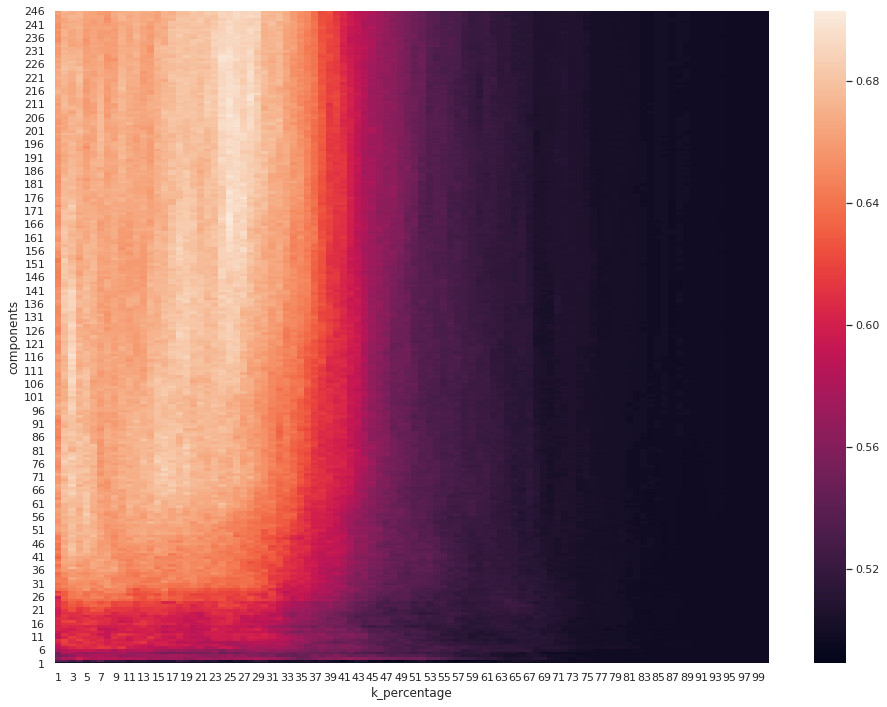

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)
plt.figure(figsize=(16, 12))
ax = sns.heatmap(dfAcc)
ax.invert_yaxis()